# Adversarial Examples For CIFAR10
Usage of adversarial attack codes on CIFAR10 dataset.

In [1]:
import sys
sys.path.append("../")

In [2]:
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import attacks
from attacks import FGSM, RFGSM, PGD

# Load Dataset

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}

transform = transforms.Compose([
    transforms.ToTensor(),
    ])

trainset = datasets.CIFAR10(root='./data', 
                            train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, 
                                           batch_size=64, 
                                           shuffle=True, **kwargs)

testset = datasets.CIFAR10(root='./data',
                           train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, 
                                          batch_size=200, 
                                          shuffle=False, **kwargs)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def show_images(images, labels):
    num_img = len(images)
    np_images = [img.numpy() for img in images]
    fig, axes = plt.subplots(nrows=1, ncols=num_img, figsize=(20, 45))

    for i, ax in enumerate(axes.flat):
        ax.set_axis_off()
        im = ax.imshow(np_images[i], vmin=0., vmax=1.)
        ax.set_title(f'{labels[i]}')
        plt.axis("off")

    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                        wspace=0.1, hspace=0.25)

    plt.show()

Let's plot the original images.

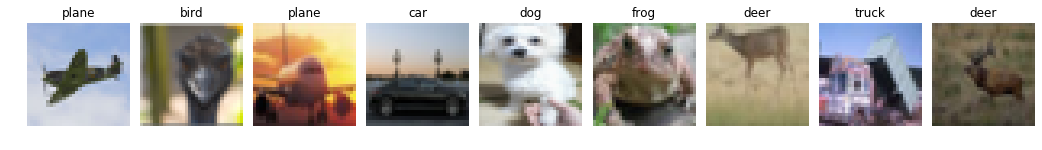

In [5]:
images, labels = iter(train_loader).next()
num_img_to_plot = 9
images = [images[i].permute(1,2,0) for i in range(num_img_to_plot)]
labels = [classes[i] for i in labels[:num_img_to_plot]]
show_images(images, labels)

In [6]:
from models.resnet import ResNet
model = ResNet().to(device)
# model.load_state_dict(torch.load("model/holdout.pth"))
# model.eval()

In [7]:
def test_adversarial(model, test_loader, data_params, attack_params):

    device = model.parameters().__next__().device

    for key in attack_params:
        print(key + ': ' + str(attack_params[key]))

    model.eval()
    test_loss = 0
    test_correct = 0
    test_load = tqdm(
                iterable=test_loader,
                unit="batch",
                leave=True,
                # bar_format="{percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}{postfix}]"
                )
    for data, target in test_load:

        data, target = data.to(device), target.to(device)

        # Attacks
        pgd_args = dict(net=model,
                        x=data,
                        y_true=target,
                        data_params=data_params,
                        attack_params=attack_params,
                        verbose=False)
        perturbs = PGD(**pgd_args)
        data += perturbs
#         print(perturbs)

        output = model(data)

        cross_ent = nn.CrossEntropyLoss()
        test_loss += cross_ent(output, target).item() * data.size(0)

        pred = output.argmax(dim=1, keepdim=True)
        test_correct += pred.eq(target.view_as(pred)).sum().item()

    test_size = len(test_loader.dataset)

    return test_loss/test_size, test_correct/test_size

In [8]:
data_params = {"x_min": 0., "x_max": 1.}
attack_params = {
    "norm": "inf",
    "eps": 8./255,
    "step_size": 2./255,
    "num_steps": 7,
    "random_start": False,
    "num_restarts": 1,
    }
attack_loss, attack_acc = test_adversarial(model, test_loader,
                                           data_params=data_params,
                                           attack_params=attack_params)
print(f'Attack  \t loss: {attack_loss:.4f} \t acc: {attack_acc:.4f}')

  0%|          | 0/50 [00:00<?, ?batch/s]

norm: inf
eps: 0.03137254901960784
step_size: 0.00784313725490196
num_steps: 7
random_start: False
num_restarts: 1


RuntimeError: invalid gradient at index 0 - expected type torch.DoubleTensor but got torch.FloatTensor